Epoch 1/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - kl_loss: 48.4165 - loss: 0.0387 - recon_loss: 0.0347
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 11.2765 - loss: 0.0035 - recon_loss: 9.9906e-04
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 9.6058 - loss: 0.0059 - recon_loss: 3.1204e-04
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 9.6008 - loss: 0.0136 - recon_loss: 1.7378e-04
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 9.6003 - loss: 0.0288 - recon_loss: 1.3297e-04
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 9.6001 - loss: 0.0508 - recon_loss: 1.0996e-04
Epoch 7/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 9.6003 - loss: 0.0717 - recon_loss: 1.0640e-04
Epoch 8/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 9.6000 - loss: 0.0851 - recon_loss: 8.0634e-05
Epoch 9/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 9.6001 - loss: 0.0916 - recon_loss: 8.1881e-05
Epo

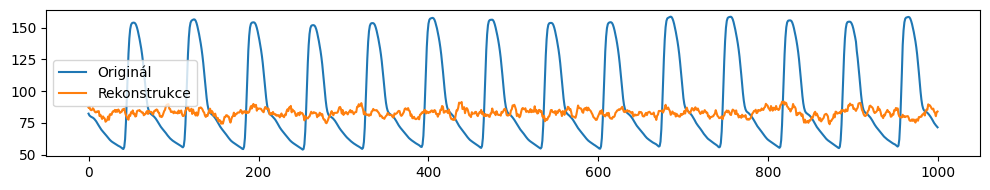

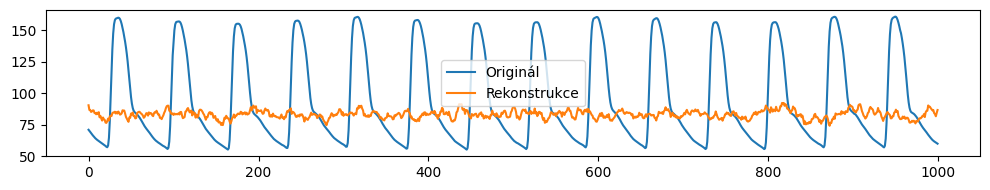

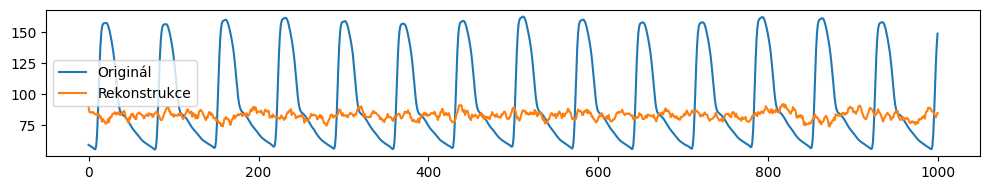

974/974 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


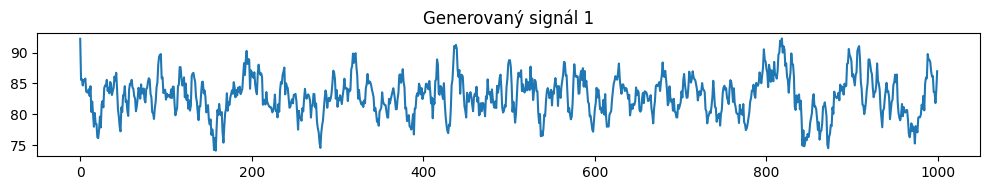

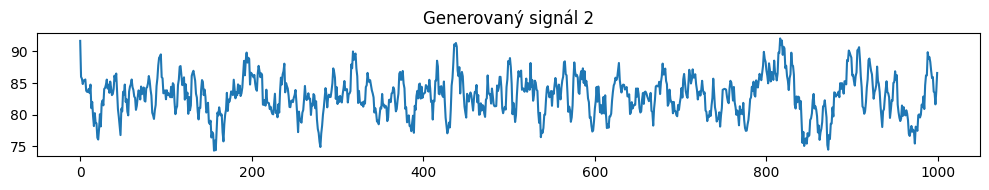

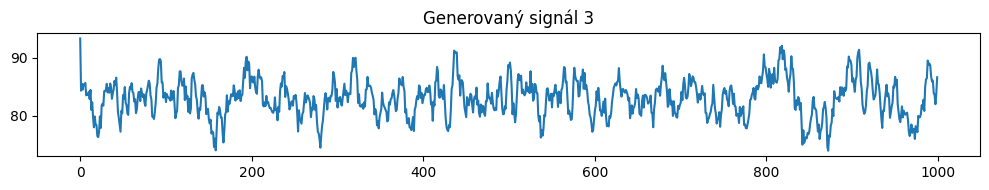

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 100
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "models2"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAČTENÍ A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

# === SAMPLING ===
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === ENCODER ===
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === DECODER ===
def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256)(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    x = layers.Activation("tanh")(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

# === VAE S ANNEALING A FREE BITS ===
class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]

        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)

            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# === CALLBACK: UKLÁDÁNÍ KAŽDÝCH 10 EPOCH ===
class SaveEveryNEpoch(tf.keras.callbacks.Callback):
    def __init__(self, n, model_dir, encoder, decoder):
        super().__init__()
        self.n = n
        self.model_dir = model_dir
        self.encoder = encoder
        self.decoder = decoder

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            enc_path = os.path.join(self.model_dir, f"vae_encoder_epoch{epoch+1:03d}.keras")
            dec_path = os.path.join(self.model_dir, f"vae_decoder_epoch{epoch+1:03d}.keras")
            self.encoder.save(enc_path)
            self.decoder.save(dec_path)
            print(f"✅ Model uložen: {enc_path}, {dec_path}")

# === TRÉNINK ===
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(
    X_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[SaveEveryNEpoch(n=10, model_dir=MODEL_DIR, encoder=encoder, decoder=decoder)]
)

# === POSLEDNÍ ULOŽENÍ ===
encoder.save(os.path.join(MODEL_DIR, "vae_encoder_final.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_final.keras"))

# === REKONSTRUKCE ===
reconstructed = decoder(encoder(X_scaled)[2]).numpy()
reconstructed = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    spectrum = reconstructed[i][:, 0] + 1j * reconstructed[i][:, 1]
    recon_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(originals[i], label="Originál")
    plt.plot(recon_time, label="Rekonstrukce")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === GENEROVÁNÍ ===
z_mean, _, _ = encoder.predict(X_scaled, batch_size=32)
noise = tf.random.normal(shape=z_mean[:3].shape, stddev=0.5)
random_latents = z_mean[:3] + noise

generated = decoder(random_latents).numpy()
generated = scaler.inverse_transform(generated.reshape(-1, 2)).reshape(generated.shape)

for i in range(3):
    spectrum = generated[i][:, 0] + 1j * generated[i][:, 1]
    gen_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(gen_time)
    plt.title(f"Generovaný signál {i+1}")
    plt.tight_layout()
    plt.show()



🔍 Epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


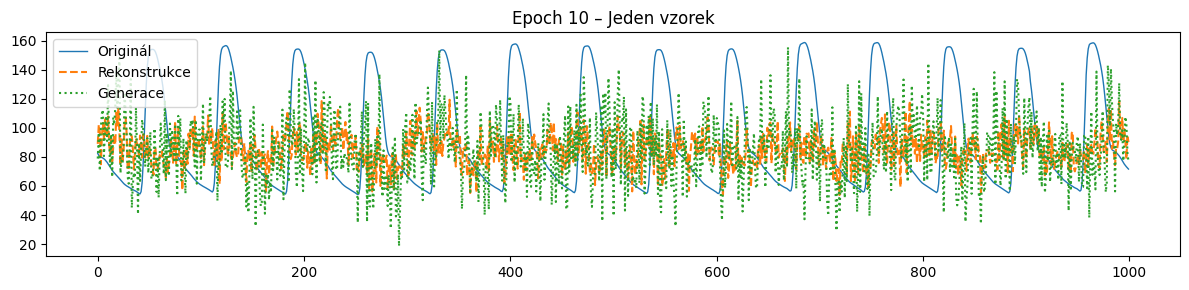


🔍 Epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


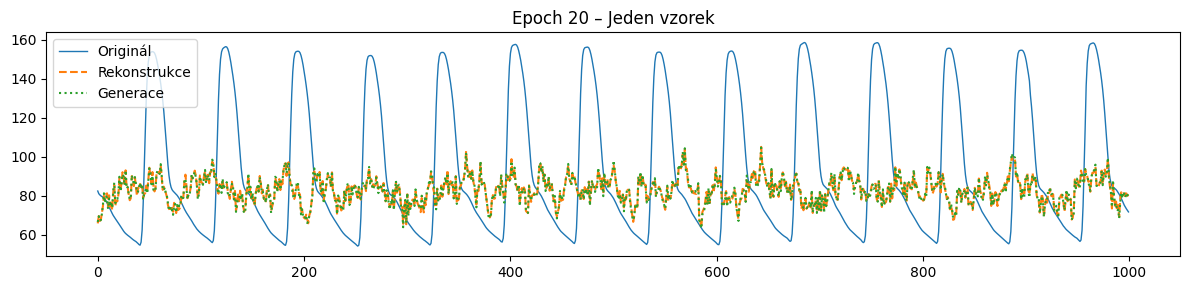


🔍 Epoch 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


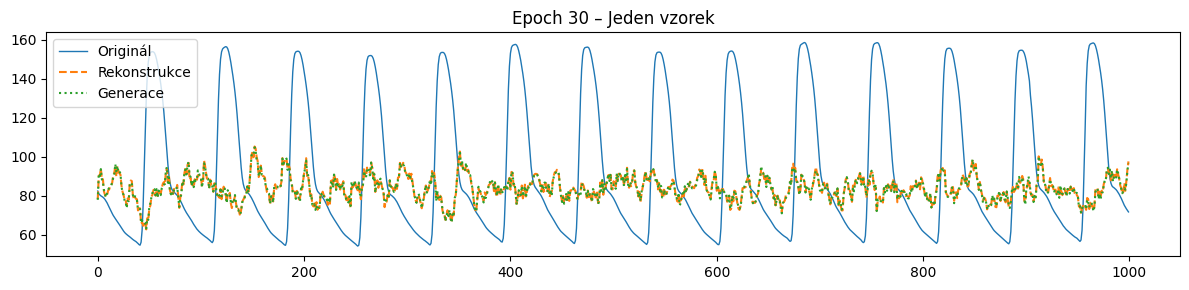


🔍 Epoch 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


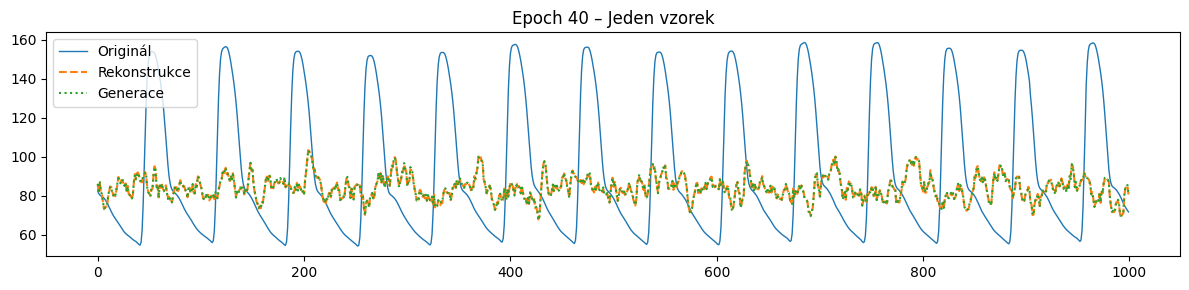


🔍 Epoch 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


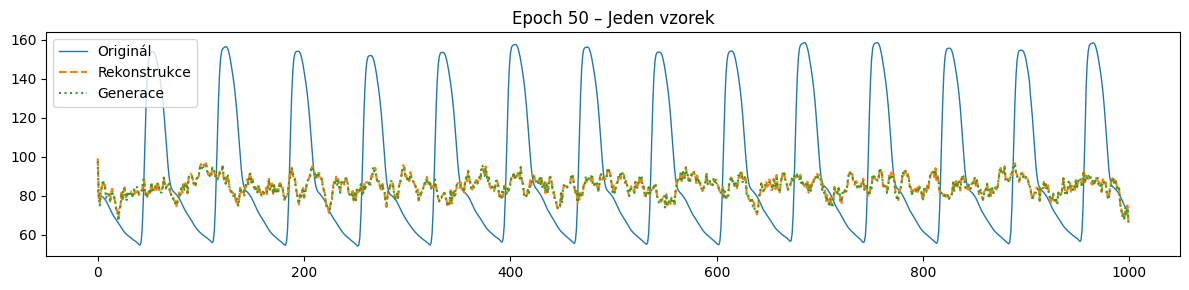


🔍 Epoch 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


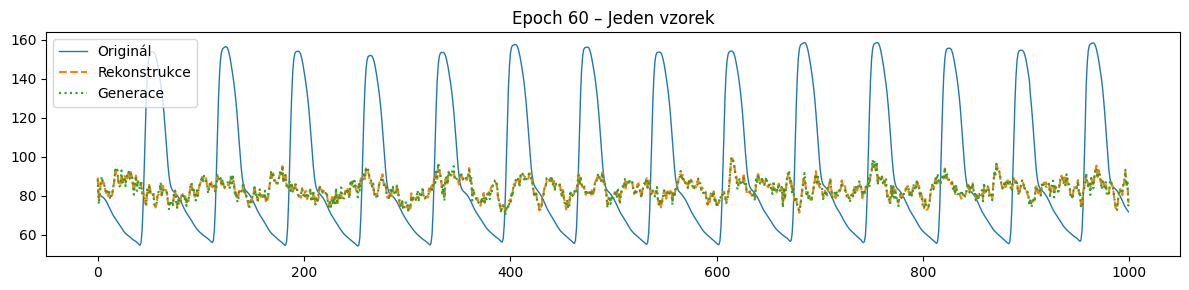


🔍 Epoch 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


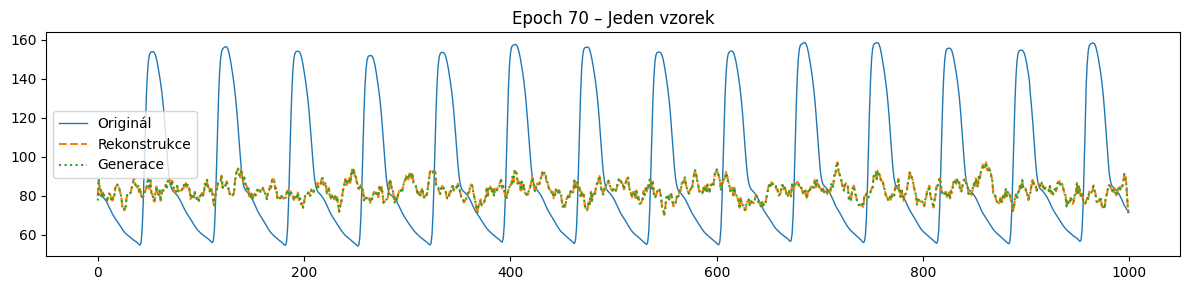


🔍 Epoch 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


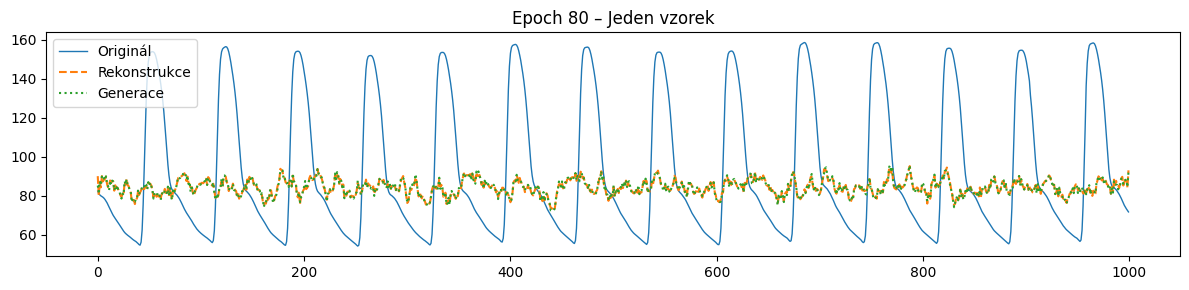


🔍 Epoch 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


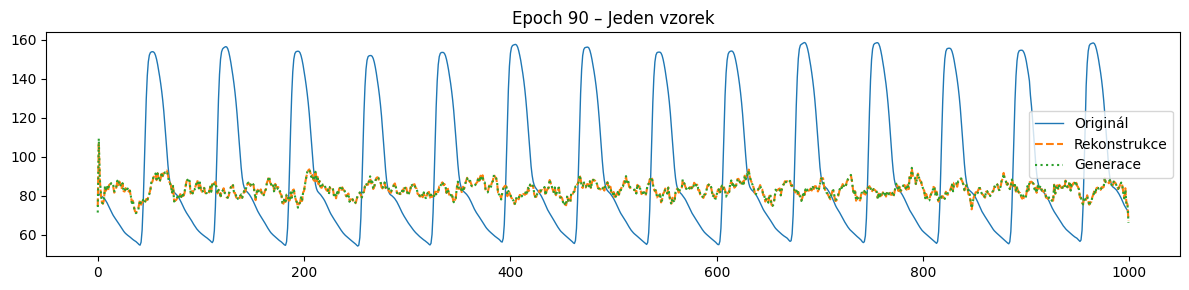


🔍 Epoch 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


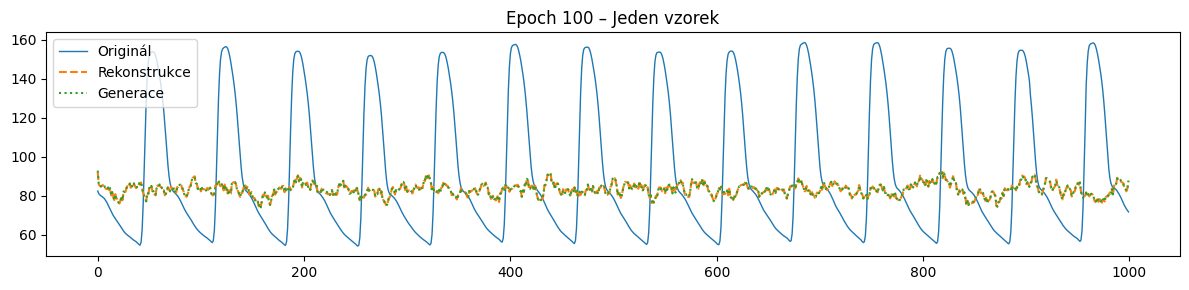

In [16]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable

# === REGISTRACE Sampling vrstvy ===
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === PARAMETRY ===
MODEL_DIR = "models2"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48

# === KONTROLA EXISTENCE DAT ===
if 'X_scaled' not in globals() or 'originals' not in globals():
    raise RuntimeError("❌ Proměnné 'X_scaled' a 'originals' nejsou načteny. Spusť tréninkový skript nebo načti data.")

# === NAČTI SCALER ===
scaler = joblib.load(SCALER_PATH)

# === MANUÁLNĚ DEFINOVANÉ MODELY ===
model_pairs = [
    ("models2/vae_encoder_epoch010.keras", "models2/vae_decoder_epoch010.keras", 10),
    ("models2/vae_encoder_epoch020.keras", "models2/vae_decoder_epoch020.keras", 20),
    ("models2/vae_encoder_epoch030.keras", "models2/vae_decoder_epoch030.keras", 30),
    ("models2/vae_encoder_epoch040.keras", "models2/vae_decoder_epoch040.keras", 40),
    ("models2/vae_encoder_epoch050.keras", "models2/vae_decoder_epoch050.keras", 50),
    ("models2/vae_encoder_epoch060.keras", "models2/vae_decoder_epoch060.keras", 60),
    ("models2/vae_encoder_epoch070.keras", "models2/vae_decoder_epoch070.keras", 70),
    ("models2/vae_encoder_epoch080.keras", "models2/vae_decoder_epoch080.keras", 80),
    ("models2/vae_encoder_epoch090.keras", "models2/vae_decoder_epoch090.keras", 90),
    ("models2/vae_encoder_epoch100.keras", "models2/vae_decoder_epoch100.keras", 100),
]

# === PROCESUJ KAŽDOU EPOCHU ===
for encoder_path, decoder_path, epoch in model_pairs:
    print(f"\n🔍 Epoch {epoch}")

    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === PRVNÍ VZOREK ===
    sample = X_scaled[0:1]
    original = originals[0]

    # === REKONSTRUKCE ===
    z = encoder.predict(sample)[2]
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE ===
    z_gen = z + np.random.normal(size=z.shape)
    gen = decoder.predict(z_gen)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === VYKRESLENÍ ===
    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.plot(gen_time, label="Generace", linestyle=":")
    plt.title(f"Epoch {epoch} – Jeden vzorek")
    plt.legend()
    plt.tight_layout()
    plt.show()



🔍 Epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


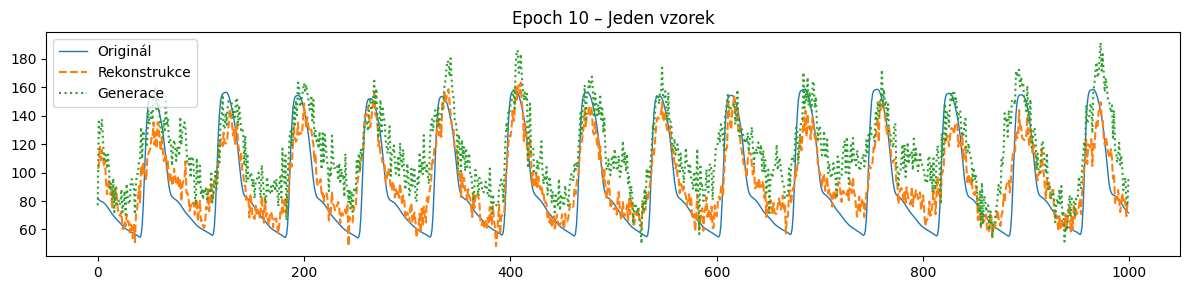


🔍 Epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


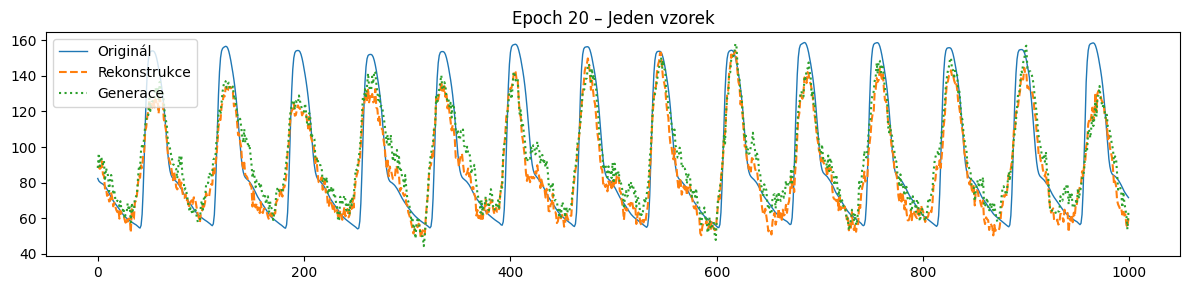


🔍 Epoch 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


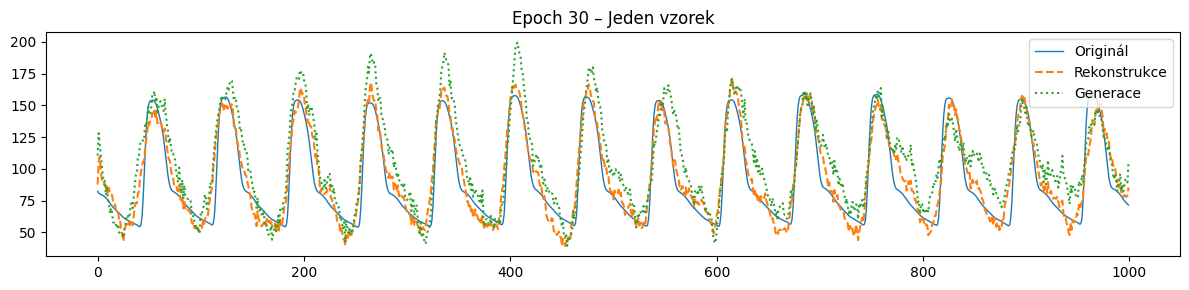

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 30
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "models2"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAHRANI A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

# === SAMPLING ===
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === ENCODER ===
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === DECODER ===
def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

# === VAE ===
class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]

        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)

            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# === TRÉNINK A PRŮBĚŽNÉ UKLÁDÁNÍ MODELŮ ===
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

for epoch in range(1, EPOCHS + 1):
    vae.fit(X_scaled, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    if epoch % 10 == 0 or epoch == EPOCHS:
        encoder.save(os.path.join(MODEL_DIR, f"vae_encoder_epoch{epoch:03d}.keras"))
        decoder.save(os.path.join(MODEL_DIR, f"vae_decoder_epoch{epoch:03d}.keras"))

# === ULOZENI POSLEDNIHO MODELU ===
encoder.save(os.path.join(MODEL_DIR, "vae_encoder_final.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_final.keras"))

# === TESTUJ VSECHNY MODELY V MODELS2 ===
model_files = sorted(os.listdir(MODEL_DIR))
encoders = [f for f in model_files if f.startswith("vae_encoder_epoch")]
decoders = [f for f in model_files if f.startswith("vae_decoder_epoch")]

model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

sample = X_scaled[0:1]
original = originals[0]

for encoder_path, decoder_path, epoch in model_pairs:
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === REKONSTRUKCE ===
    z = encoder.predict(sample)[2]
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE ===
    z_gen = z + np.random.normal(size=z.shape)
    gen = decoder.predict(z_gen)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === GRAF ===
    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.plot(gen_time, label="Generace", linestyle=":")
    plt.title(f"Epoch {epoch} – Jeden vzorek")
    plt.legend()
    plt.tight_layout()
    plt.show()


epocha: 1
epocha: 2
epocha: 3
epocha: 4
epocha: 5
epocha: 6
epocha: 7
epocha: 8
epocha: 9
epocha: 10
epocha: 11
epocha: 12
epocha: 13
epocha: 14
epocha: 15
epocha: 16
epocha: 17
epocha: 18
epocha: 19
epocha: 20
epocha: 21
epocha: 22
epocha: 23
epocha: 24
epocha: 25
epocha: 26
epocha: 27
epocha: 28
epocha: 29
epocha: 30
epocha: 31
epocha: 32
epocha: 33
epocha: 34
epocha: 35
epocha: 36
epocha: 37
epocha: 38
epocha: 39
epocha: 40
epocha: 41
epocha: 42
epocha: 43
epocha: 44
epocha: 45
epocha: 46
epocha: 47
epocha: 48
epocha: 49
epocha: 50
epocha: 51
epocha: 52
epocha: 53
epocha: 54
epocha: 55
epocha: 56
epocha: 57
epocha: 58
epocha: 59
epocha: 60
epocha: 61
epocha: 62
epocha: 63
epocha: 64
epocha: 65
epocha: 66
epocha: 67
epocha: 68
epocha: 69
epocha: 70
epocha: 71
epocha: 72
epocha: 73
epocha: 74
epocha: 75
epocha: 76
epocha: 77
epocha: 78
epocha: 79
epocha: 80
epocha: 81
epocha: 82
epocha: 83
epocha: 84
epocha: 85
epocha: 86
epocha: 87
epocha: 88
epocha: 89
epocha: 90
epocha: 91
epocha: 

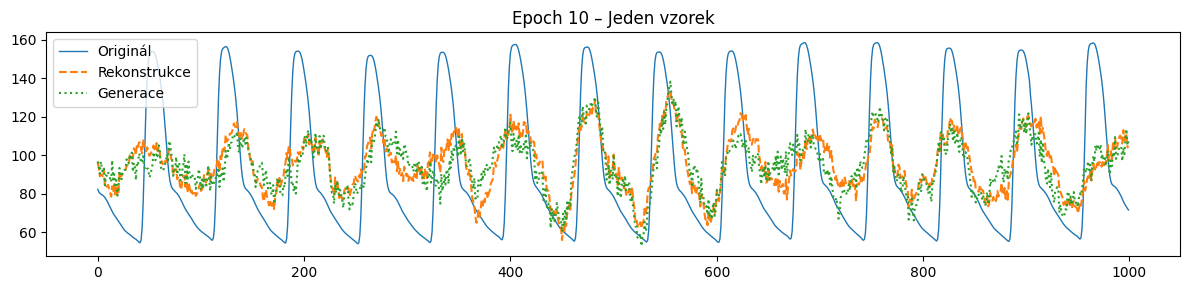


🔍 Epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


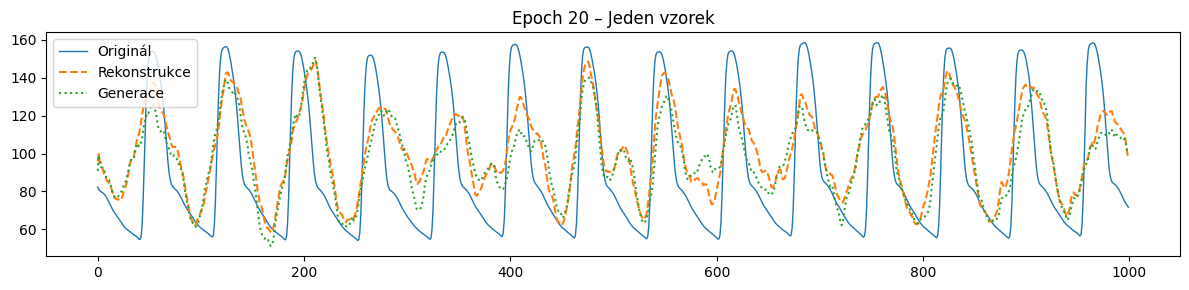


🔍 Epoch 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


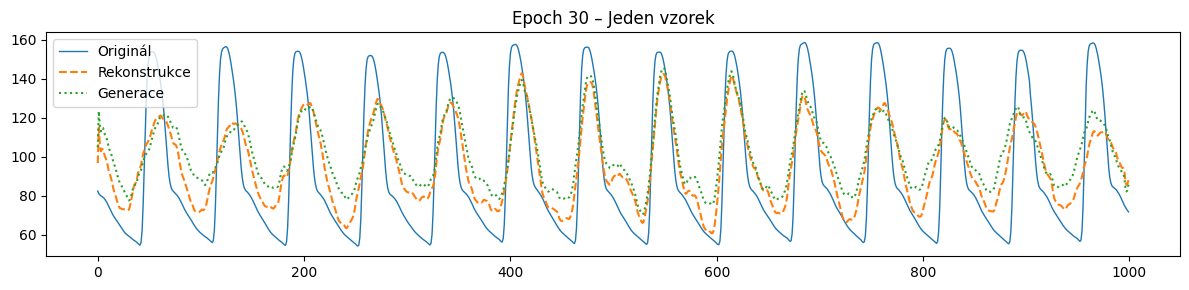


🔍 Epoch 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


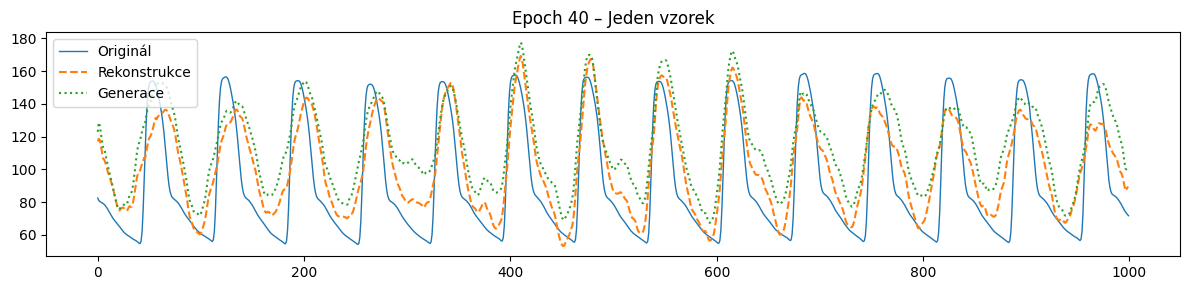


🔍 Epoch 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


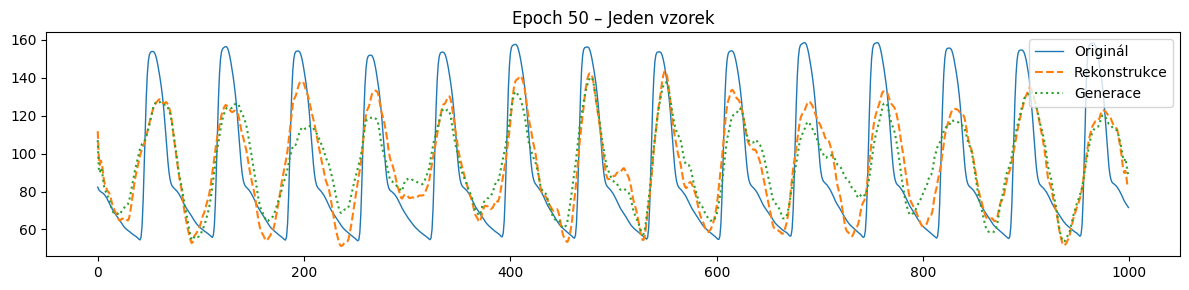


🔍 Epoch 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


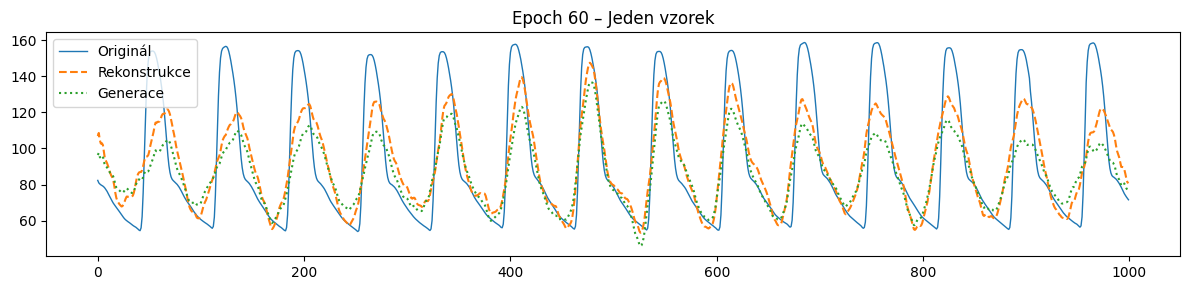


🔍 Epoch 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


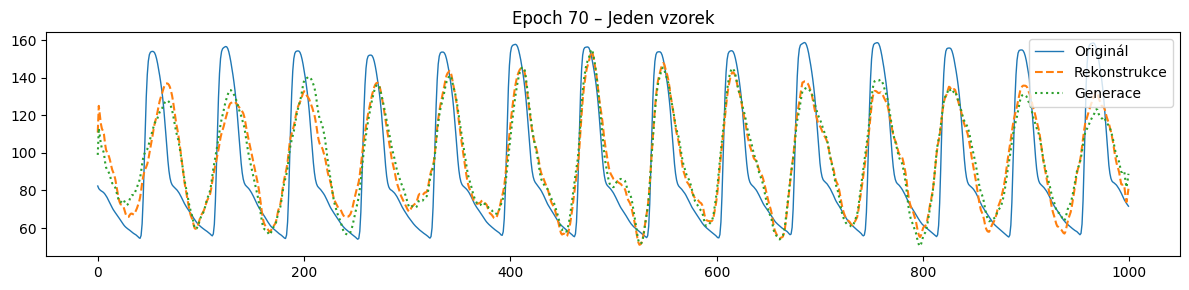


🔍 Epoch 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


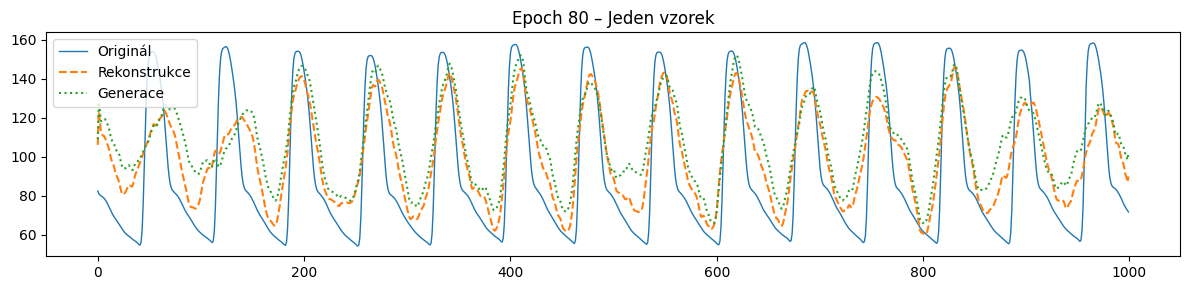


🔍 Epoch 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


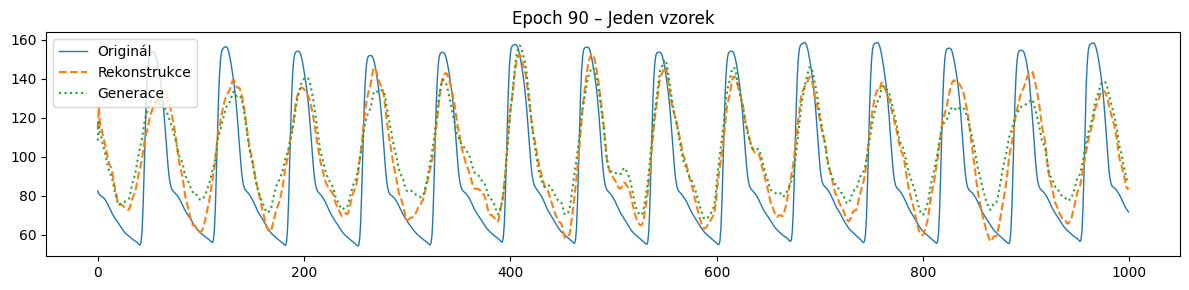


🔍 Epoch 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


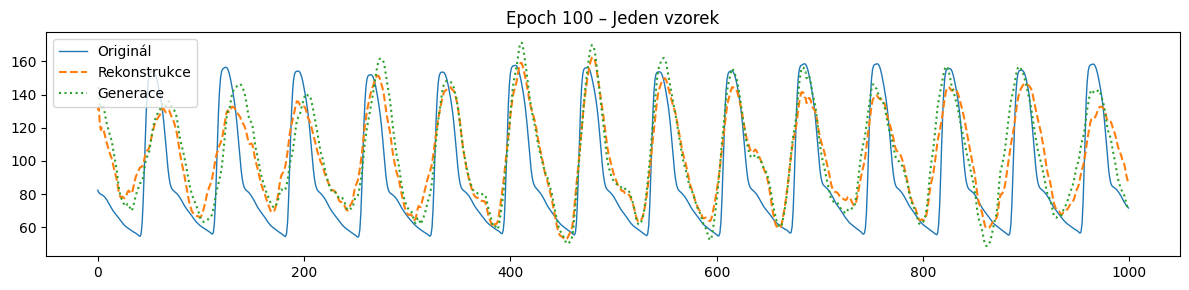

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 100
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "modelsHyper"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAHRANI A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

# === SAMPLING ===
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === ENCODER ===
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === DECODER ===
def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

# === VAE ===
class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]

        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)

            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# === TRÉNINK A PRŮBĚŽNÉ UKLÁDÁNÍ MODELŮ ===
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

for epoch in range(1, EPOCHS + 1):
    print(f"epocha: {epoch}")
    vae.fit(X_scaled, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    if epoch % 10 == 0 or epoch == EPOCHS:
        encoder.save(os.path.join(MODEL_DIR, f"vae_encoder_epoch{epoch:03d}.keras"))
        decoder.save(os.path.join(MODEL_DIR, f"vae_decoder_epoch{epoch:03d}.keras"))

# === ULOZENI POSLEDNIHO MODELU ===
encoder.save(os.path.join(MODEL_DIR, "vae_encoder_final.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_final.keras"))

# === TESTUJ VSECHNY MODELY V MODELS2 ===
model_files = sorted(os.listdir(MODEL_DIR))
encoders = [f for f in model_files if f.startswith("vae_encoder_epoch")]
decoders = [f for f in model_files if f.startswith("vae_decoder_epoch")]

model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

sample = X_scaled[0:1]
original = originals[0]

for encoder_path, decoder_path, epoch in model_pairs:
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === REKONSTRUKCE ===
    z = encoder.predict(sample)[2]
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE ===
    z_gen = z + np.random.normal(size=z.shape)
    gen = decoder.predict(z_gen)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === GRAF ===
    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.plot(gen_time, label="Generace", linestyle=":")
    plt.title(f"Epoch {epoch} – Jeden vzorek")
    plt.legend()
    plt.tight_layout()
    plt.show()



🔍 Epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


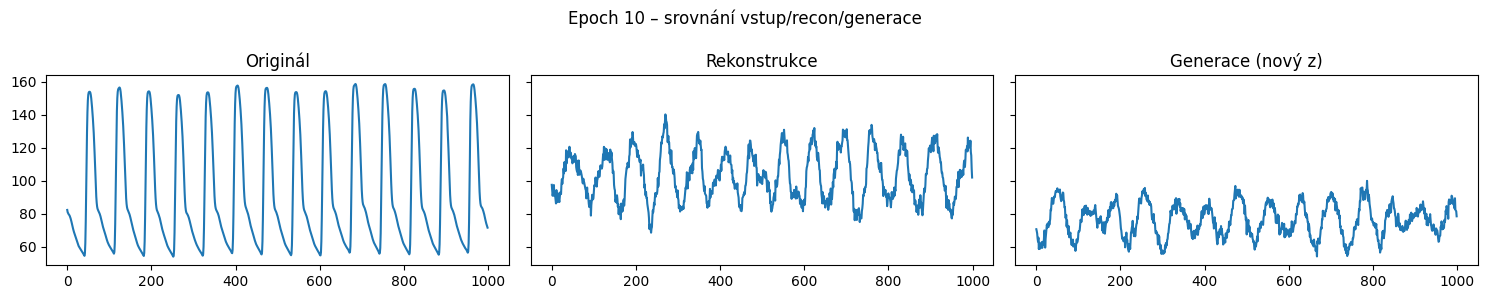


🔍 Epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


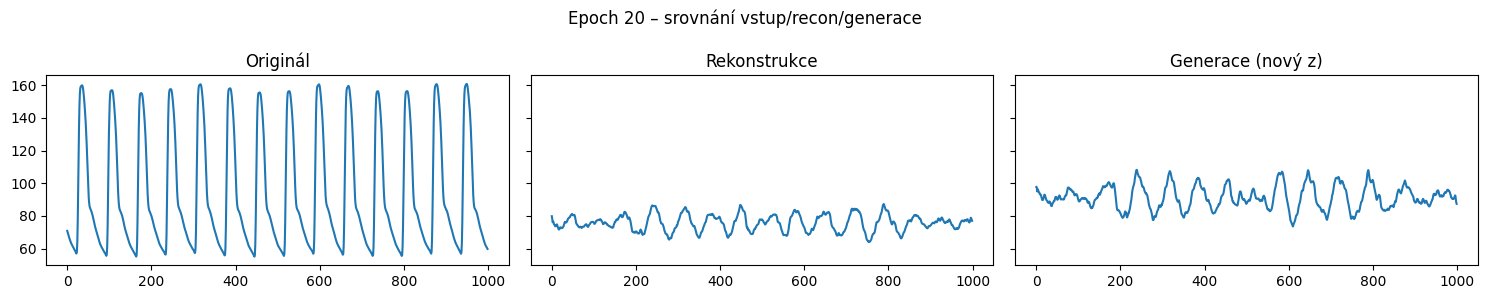


🔍 Epoch 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


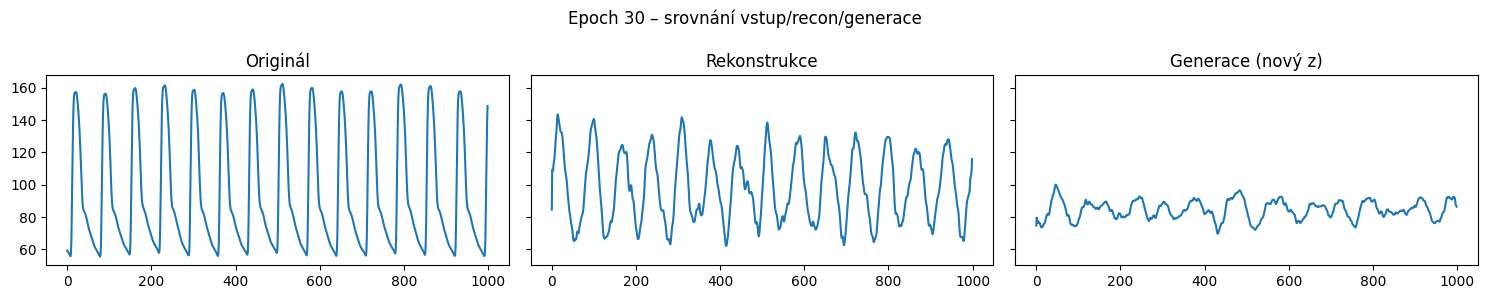


🔍 Epoch 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


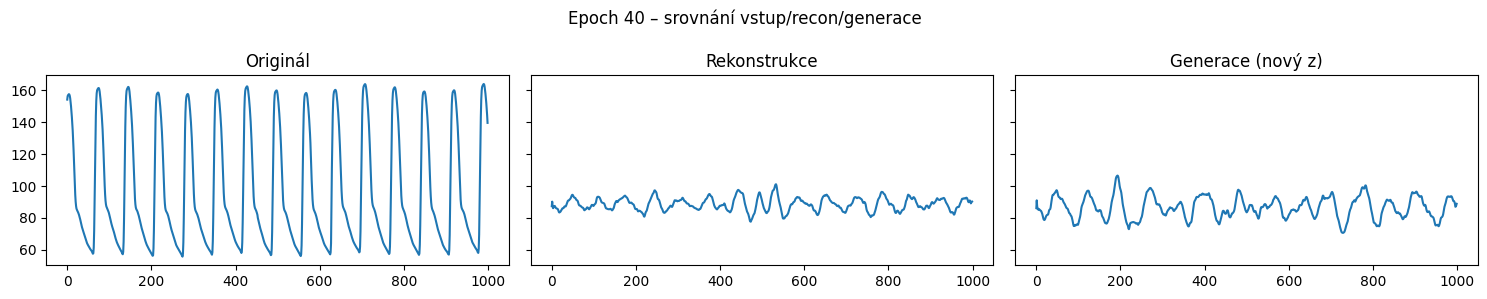


🔍 Epoch 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


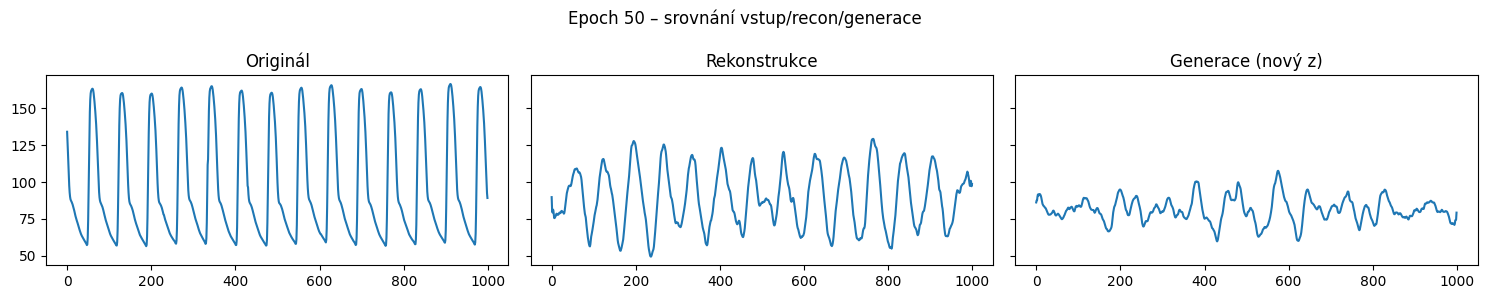


🔍 Epoch 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


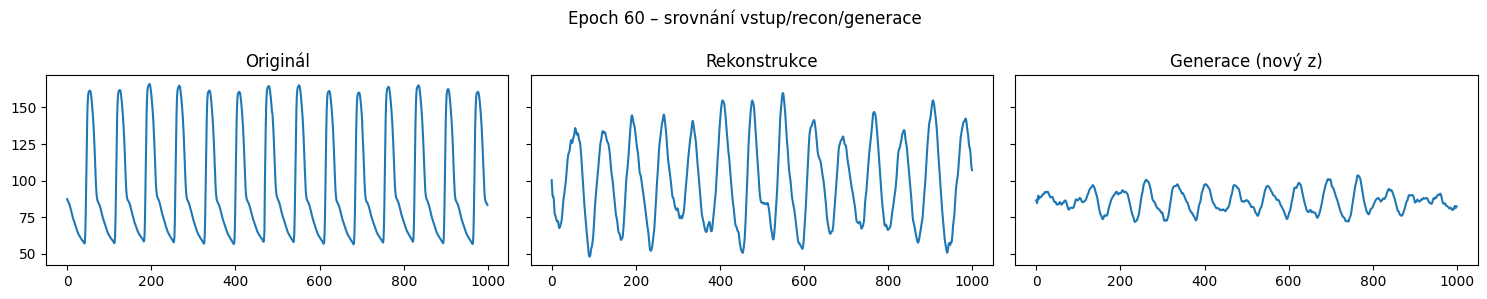


🔍 Epoch 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


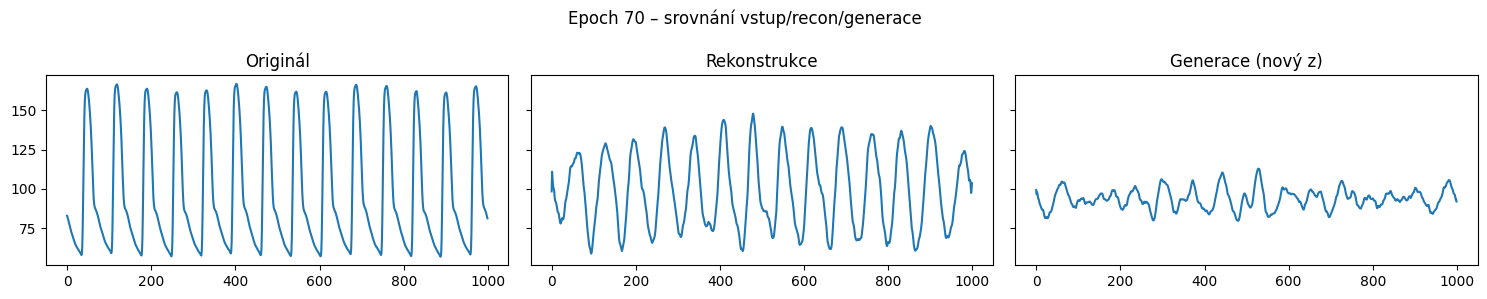


🔍 Epoch 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


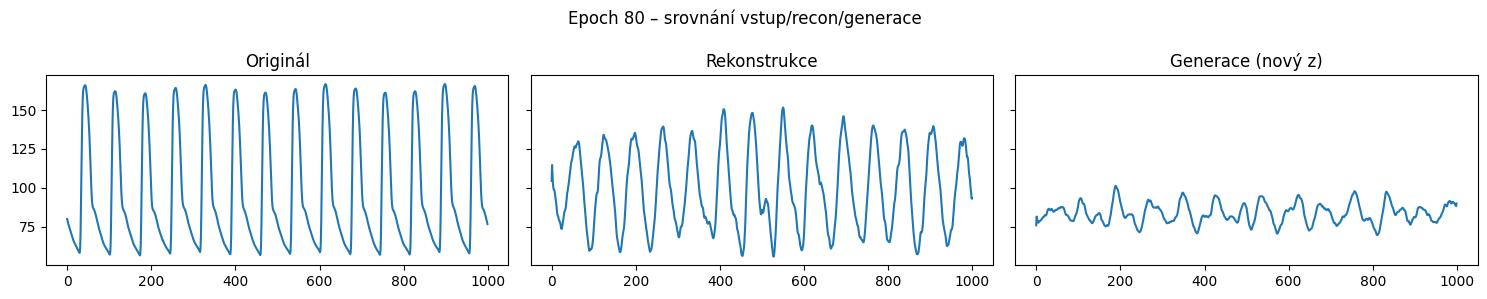


🔍 Epoch 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


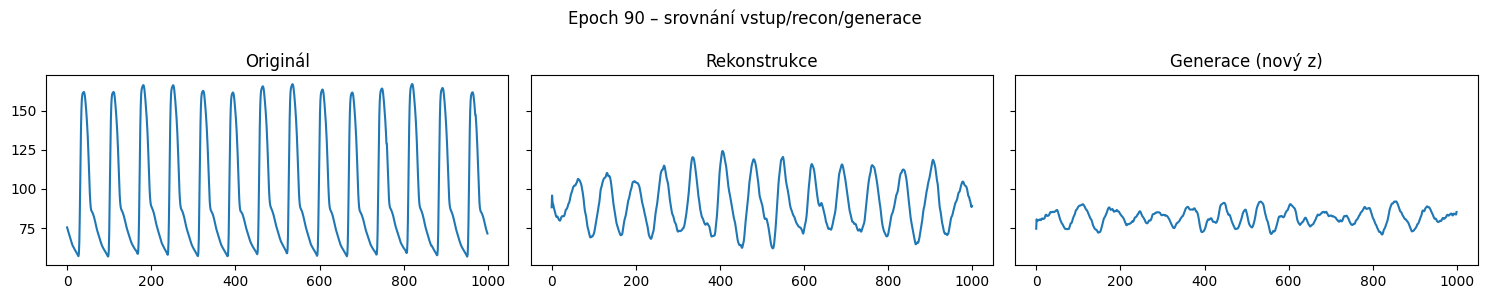


🔍 Epoch 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


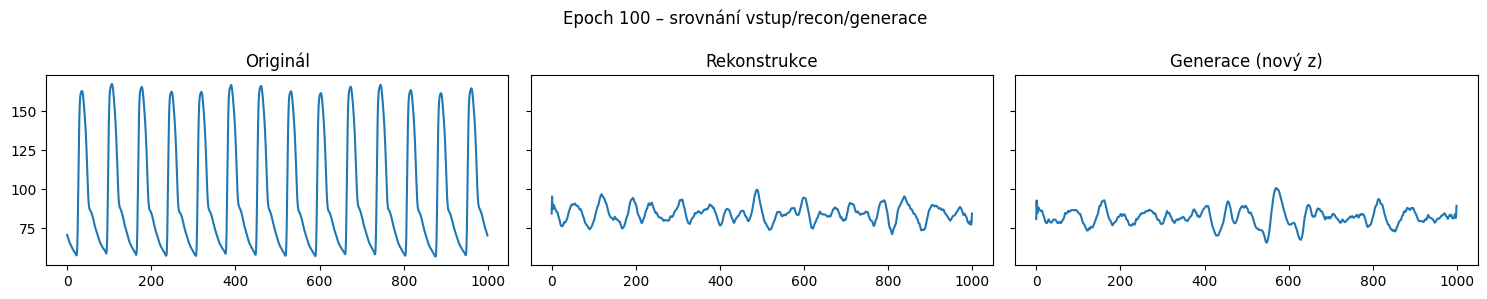

In [25]:
...

for idx, (encoder_path, decoder_path, epoch) in enumerate(model_pairs):
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === VSTUPNÍ VZOREK ===
    sample = X_scaled[idx % len(X_scaled)][None, ...]  # jiný vzorek pro každou epochu
    original = originals[idx % len(originals)]

    # === REKONSTRUKCE ===
    z_mean, z_log_var, z = encoder.predict(sample)
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE (nový náhodný vzorek) ===
    z_new = np.random.normal(size=z.shape)
    gen = decoder.predict(z_new)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === GRAF V SUBPLOTECH ===
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
    axs[0].plot(original)
    axs[0].set_title("Originál")

    axs[1].plot(recon_time)
    axs[1].set_title("Rekonstrukce")

    axs[2].plot(gen_time)
    axs[2].set_title("Generace (nový z)")

    fig.suptitle(f"Epoch {epoch} – srovnání vstup/recon/generace")
    plt.tight_layout()
    plt.show()


Epocha: 1
Epocha: 2
Epocha: 3
Epocha: 4
Epocha: 5
Epocha: 6
Epocha: 7
Epocha: 8
Epocha: 9
Epocha: 10
Epocha: 11
Epocha: 12
Epocha: 13
Epocha: 14
Epocha: 15
Epocha: 16
Epocha: 17
Epocha: 18
Epocha: 19
Epocha: 20
Epocha: 21
Epocha: 22
Epocha: 23
Epocha: 24
Epocha: 25
Epocha: 26
Epocha: 27
Epocha: 28
Epocha: 29
Epocha: 30
Epocha: 31
Epocha: 32
Epocha: 33
Epocha: 34
Epocha: 35
Epocha: 36
Epocha: 37
Epocha: 38
Epocha: 39
Epocha: 40
Epocha: 41
Epocha: 42
Epocha: 43
Epocha: 44
Epocha: 45
Epocha: 46
Epocha: 47
Epocha: 48
Epocha: 49
Epocha: 50
Epocha: 51
Epocha: 52
Epocha: 53
Epocha: 54
Epocha: 55
Epocha: 56
Epocha: 57
Epocha: 58
Epocha: 59
Epocha: 60
Epocha: 61
Epocha: 62
Epocha: 63
Epocha: 64
Epocha: 65
Epocha: 66
Epocha: 67
Epocha: 68
Epocha: 69
Epocha: 70
Epocha: 71
Epocha: 72
Epocha: 73
Epocha: 74
Epocha: 75
Epocha: 76
Epocha: 77
Epocha: 78
Epocha: 79
Epocha: 80
Epocha: 81
Epocha: 82
Epocha: 83
Epocha: 84
Epocha: 85
Epocha: 86
Epocha: 87
Epocha: 88
Epocha: 89
Epocha: 90
Epocha: 91
Epocha: 

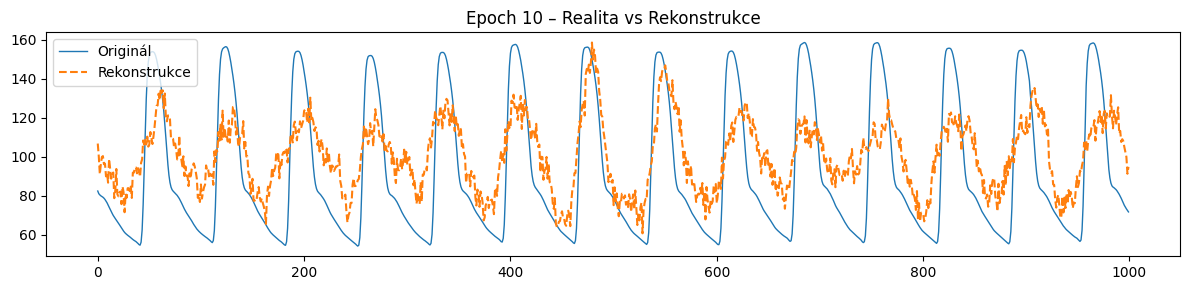

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


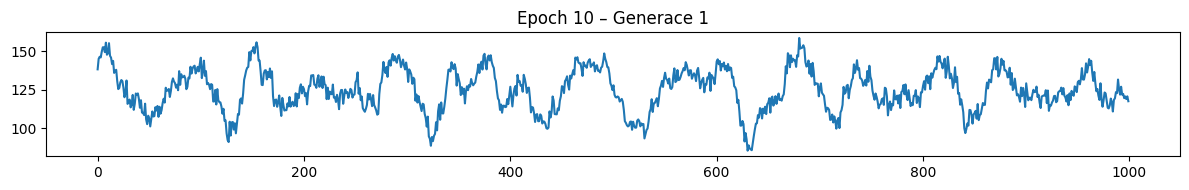

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


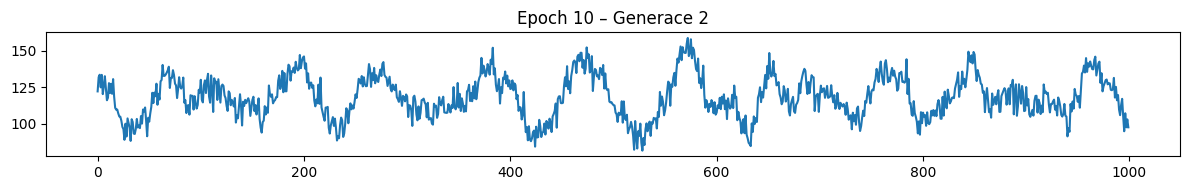

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


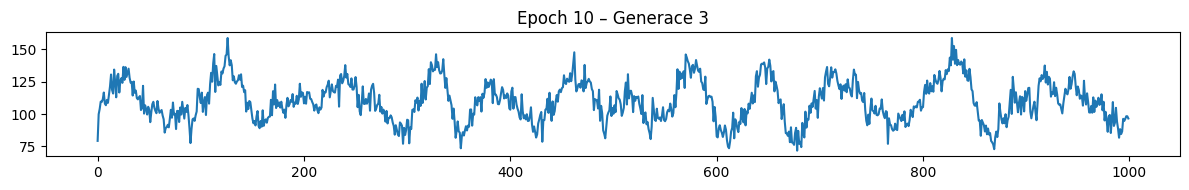


🔍 Epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


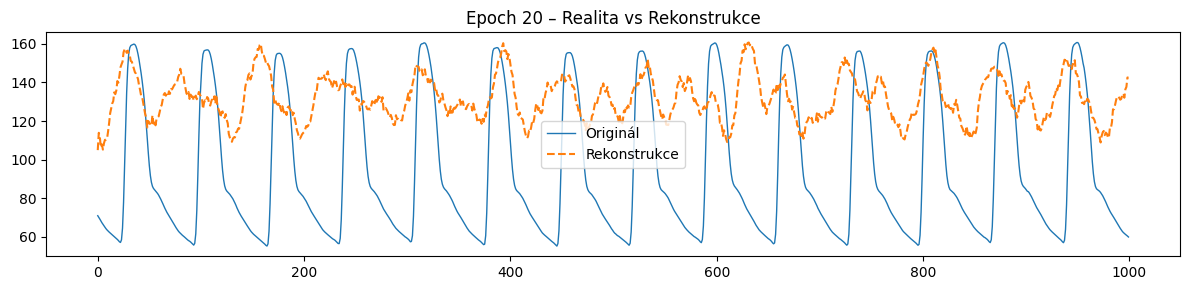

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


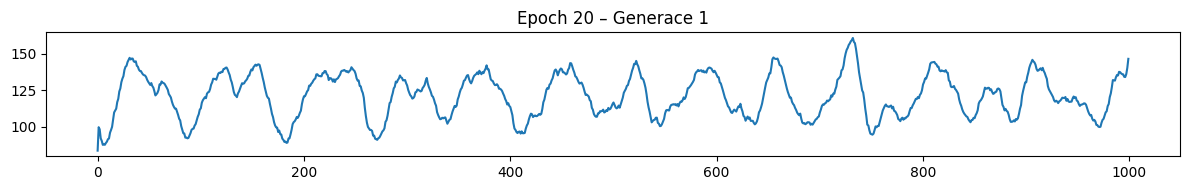

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


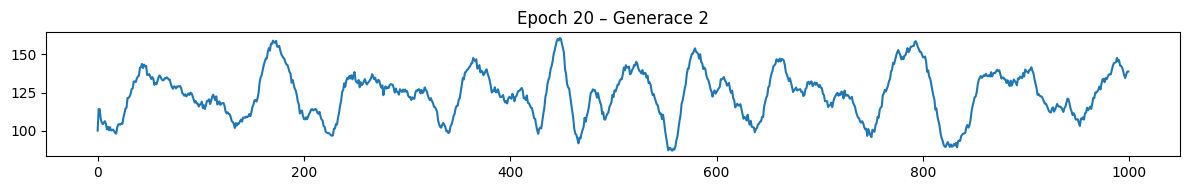

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


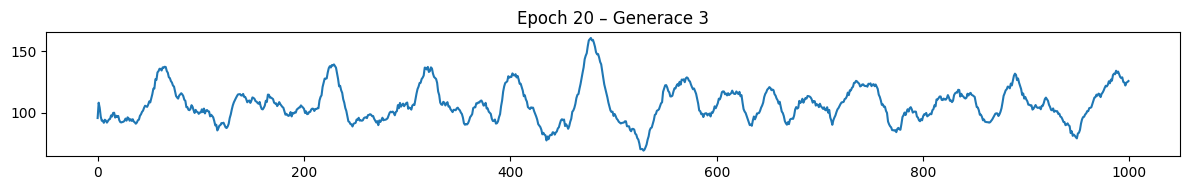


🔍 Epoch 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


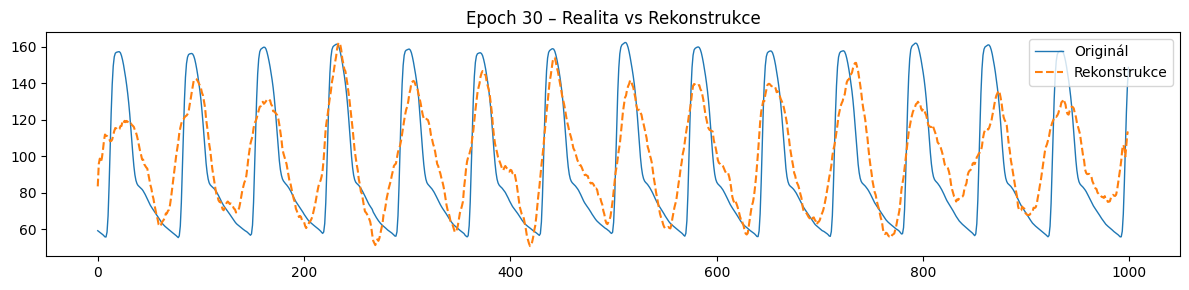

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


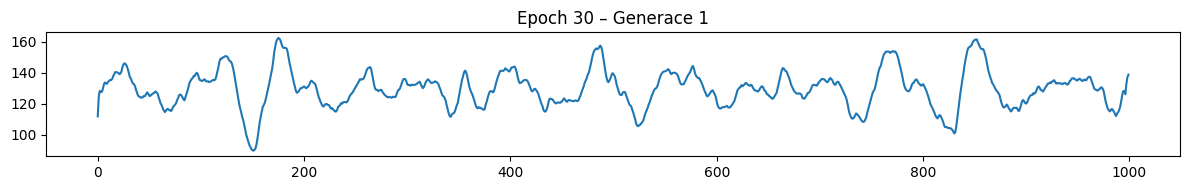

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


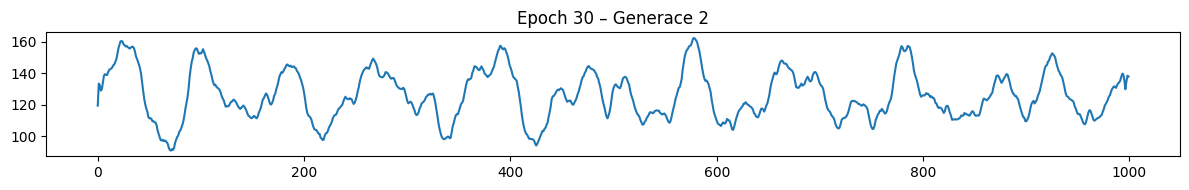

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


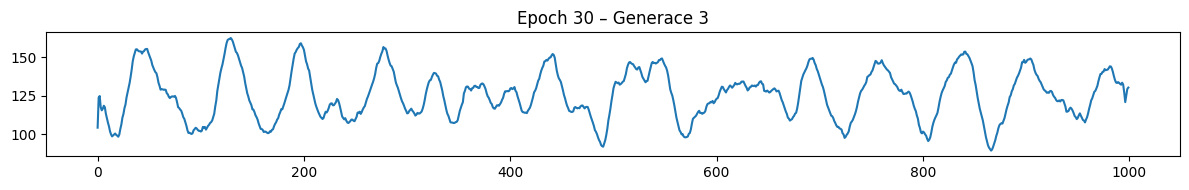


🔍 Epoch 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


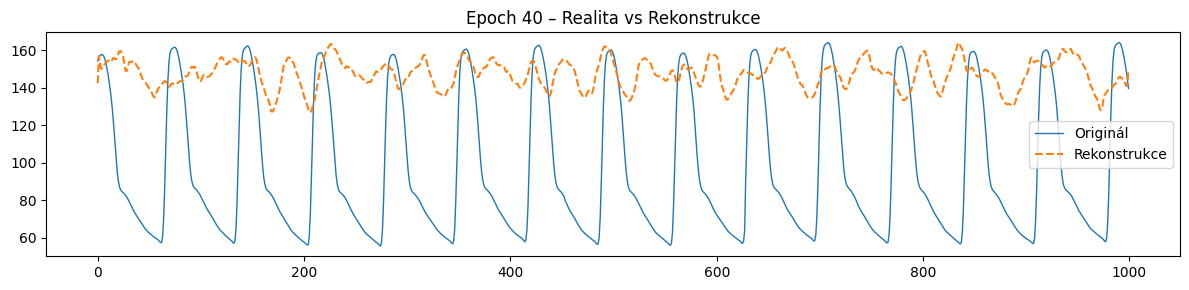

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


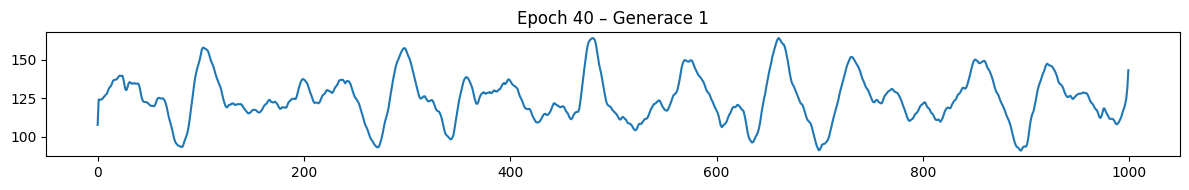

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


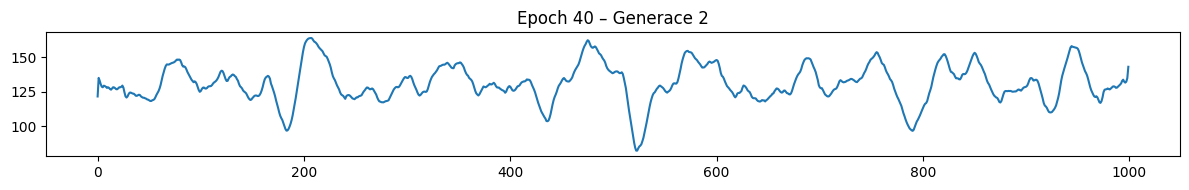

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


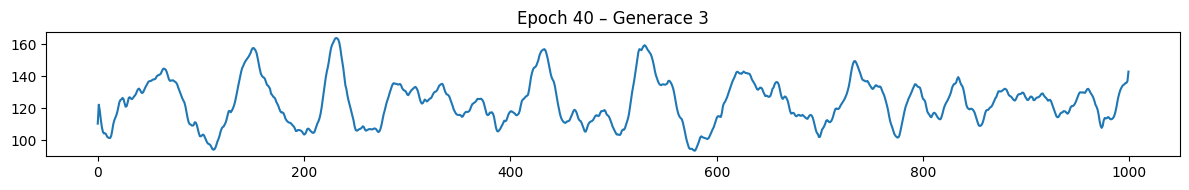


🔍 Epoch 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


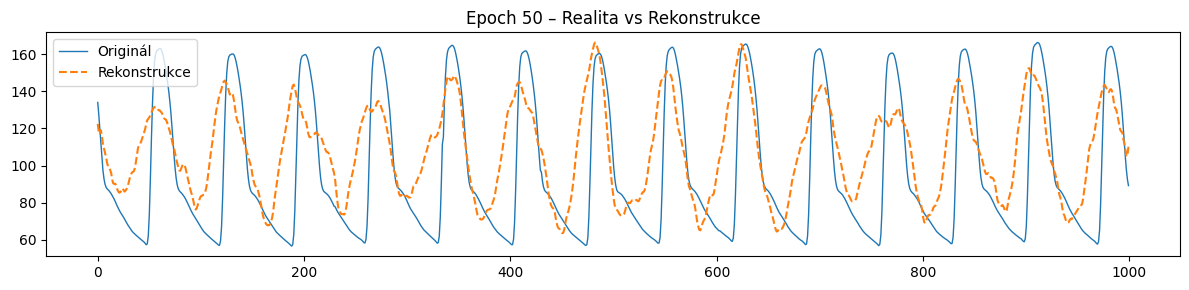

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


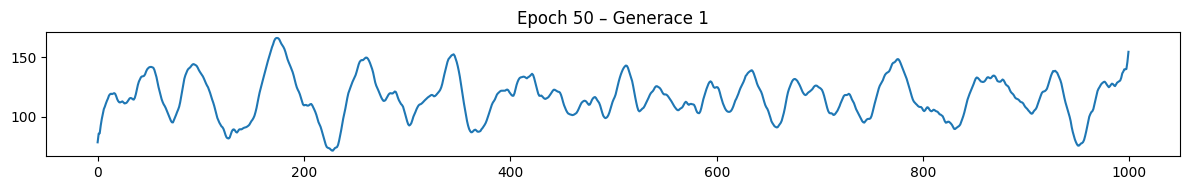

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


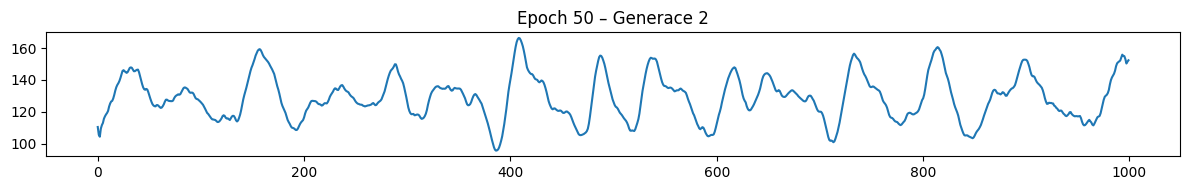

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


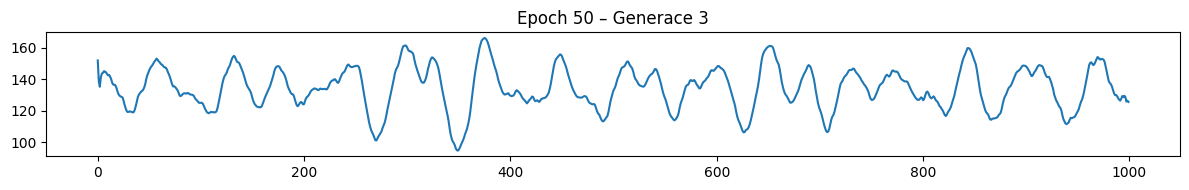


🔍 Epoch 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


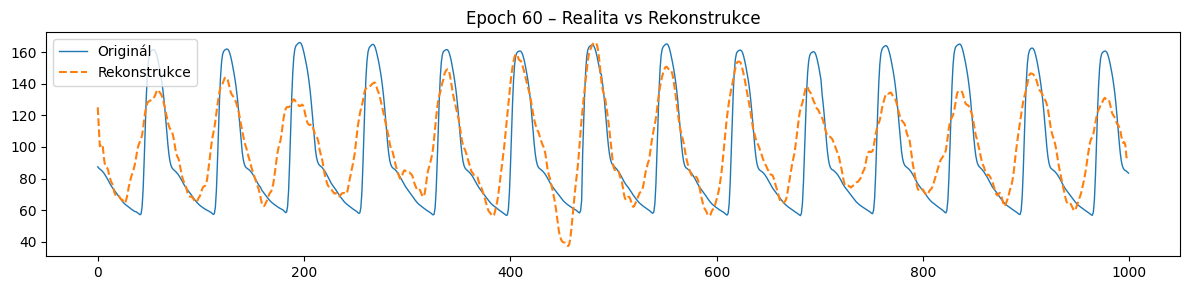

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


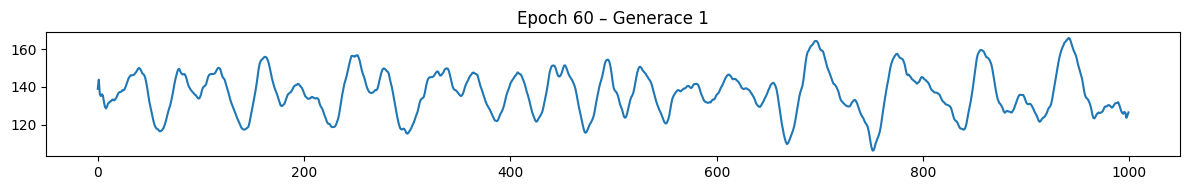

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


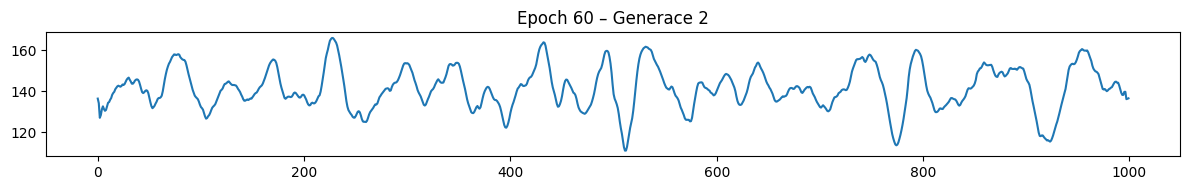

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


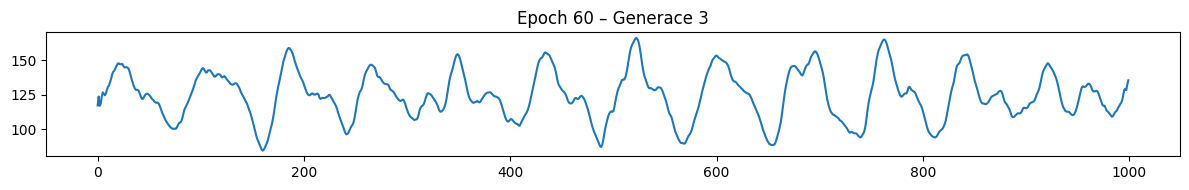


🔍 Epoch 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


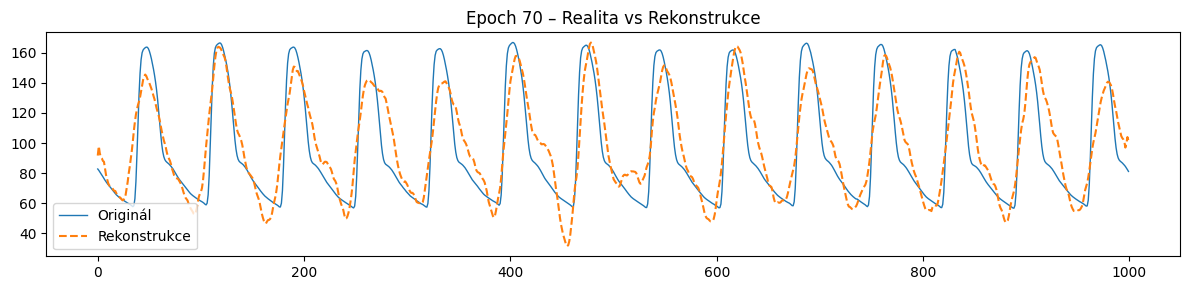

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


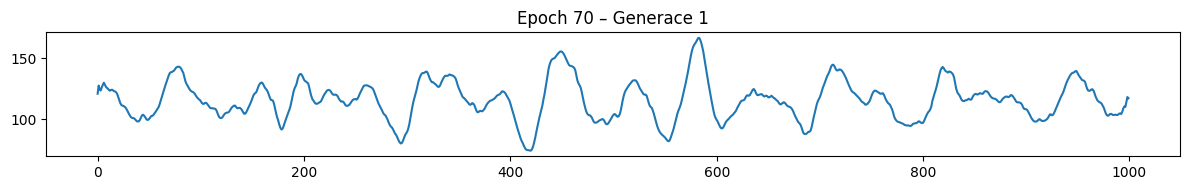

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


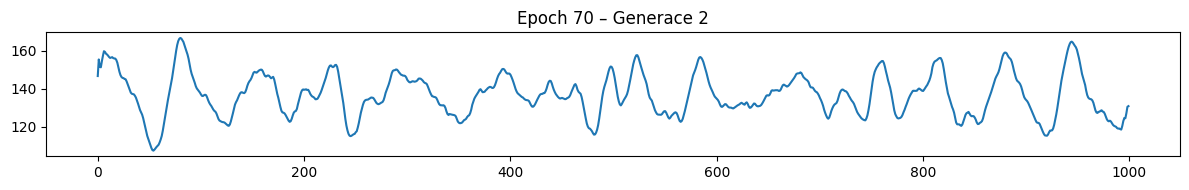

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


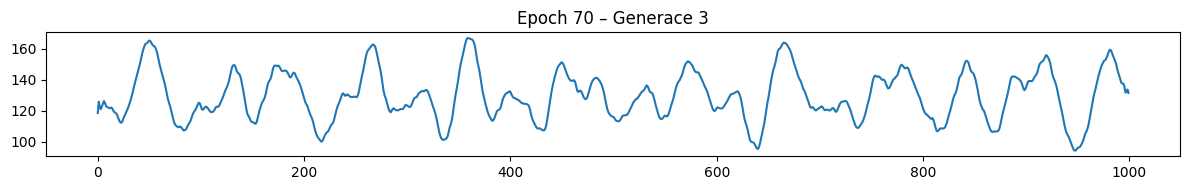


🔍 Epoch 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


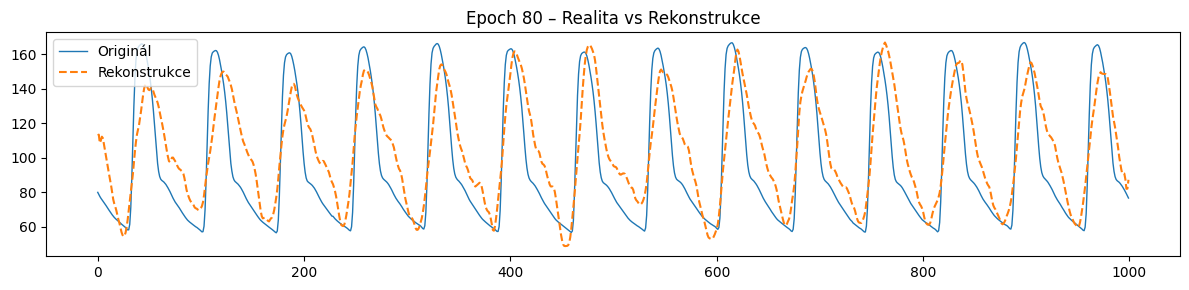

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


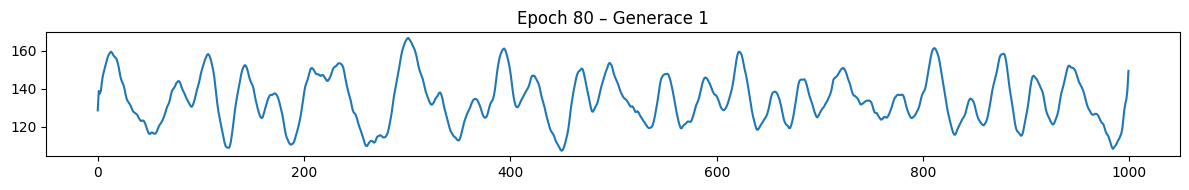

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


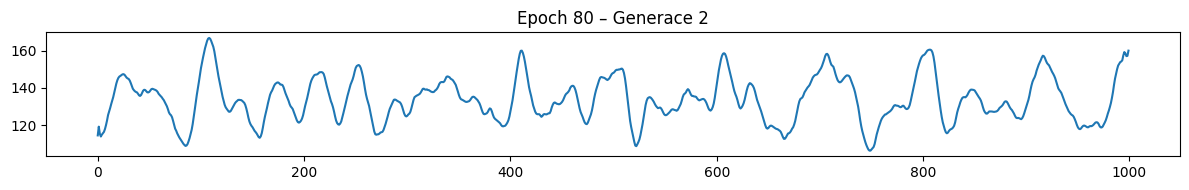

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


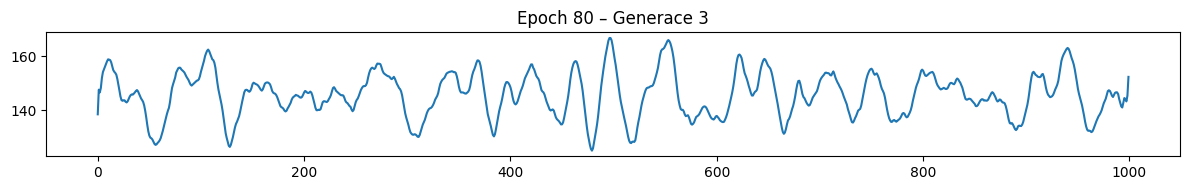


🔍 Epoch 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


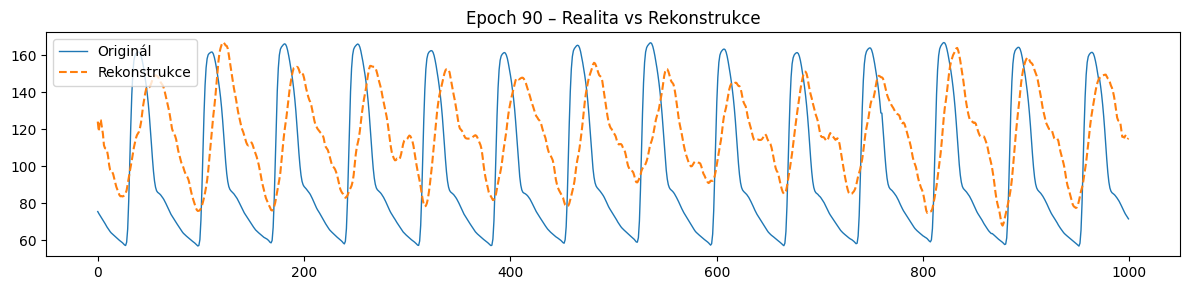

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


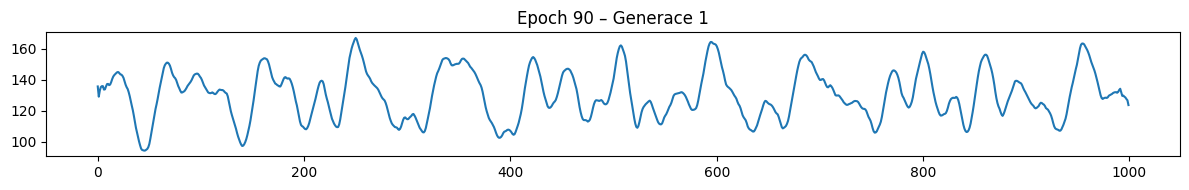

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


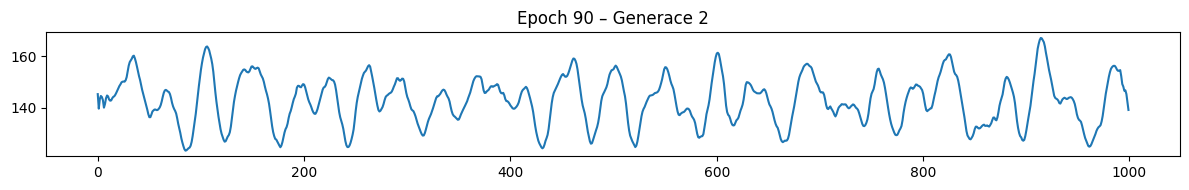

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


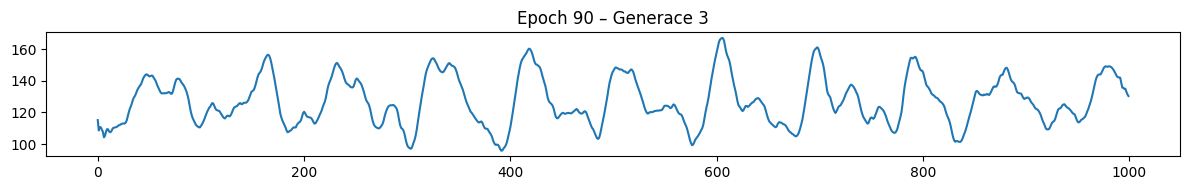


🔍 Epoch 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


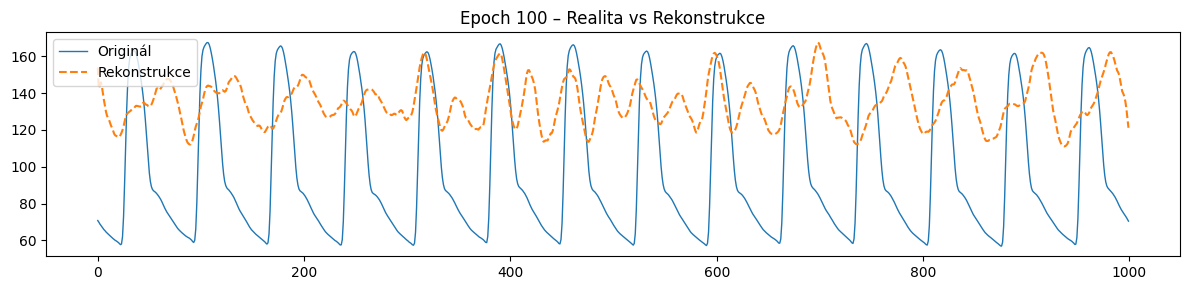

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


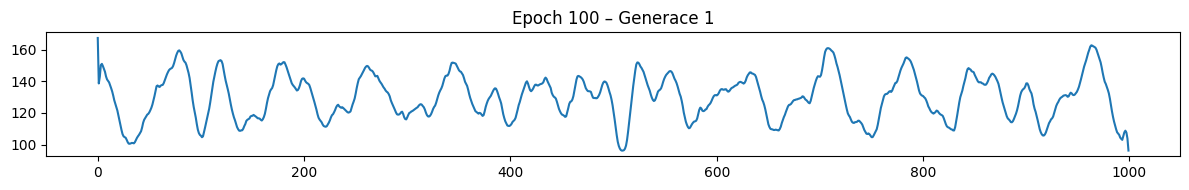

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


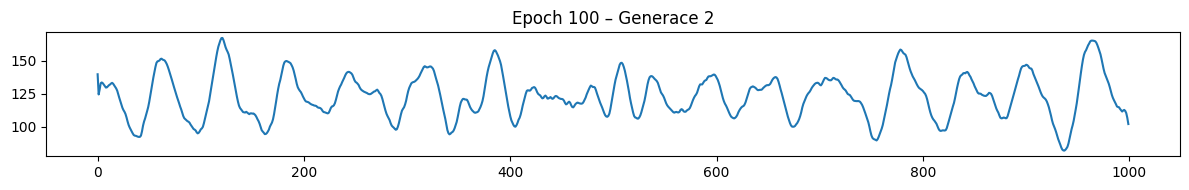

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


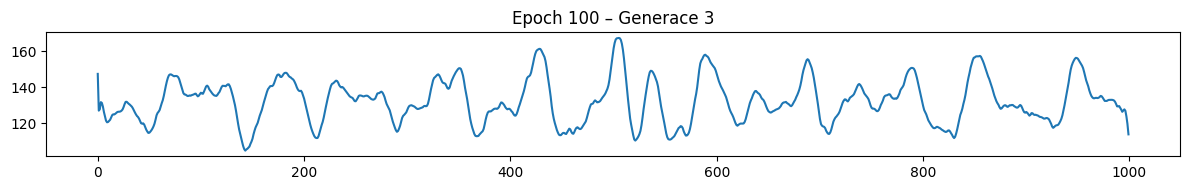

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 100
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "modelpokus"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAHRANI A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

for epoch in range(1, EPOCHS + 1):
    print(f"Epocha: {epoch}")
    vae.fit(X_scaled, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    if epoch % 10 == 0 or epoch == EPOCHS:
        encoder.save(os.path.join(MODEL_DIR, f"vae_encoder_epoch{epoch:03d}.keras"))
        decoder.save(os.path.join(MODEL_DIR, f"vae_decoder_epoch{epoch:03d}.keras"))

# === TESTOVÁNÍ MODELŮ ===
model_files = sorted(os.listdir(MODEL_DIR))
encoders = [f for f in model_files if f.startswith("vae_encoder_epoch")]
decoders = [f for f in model_files if f.startswith("vae_decoder_epoch")]
model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

# === VIZUALIZACE ===
for idx, (encoder_path, decoder_path, epoch) in enumerate(model_pairs):
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    sample = X_scaled[idx % len(X_scaled)][None, ...]
    original = originals[idx % len(originals)]

    z_mean, z_log_var, z = encoder.predict(sample)
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    recon_time *= np.max(np.abs(original)) / (np.max(np.abs(recon_time)) + 1e-8)

    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.title(f"Epoch {epoch} – Realita vs Rekonstrukce")
    plt.legend()
    plt.tight_layout()
    plt.show()

    for i in range(3):
        z_new = np.random.normal(size=z.shape)
        gen = decoder.predict(z_new)
        gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
        gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
        gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)
        gen_time *= np.max(np.abs(original)) / (np.max(np.abs(gen_time)) + 1e-8)

        plt.figure(figsize=(12, 2))
        plt.plot(gen_time)
        plt.title(f"Epoch {epoch} – Generace {i+1}")
        plt.tight_layout()
        plt.show()
